In [39]:
import pandas as pd
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import numpy as np

# Bayesan network

Let's load the dataset first in order to create a bayesan network.

In [40]:
data = pd.read_csv("data/data.csv")
data.date = pd.to_datetime(data.date)

Network structure will be the following:

![](./bayesan_network.drawio.svg)

### Create CPDs

In [41]:
state_names = {}

#### $P(Group)$

Given $g$ an arbitrary group then the probability of being in a country $c$ is
$$P(Group = g) = \frac{population_g}{\sum_g population_g}$$

In [42]:
group_pop = data.groupby("country_id").first().groupby("sdg_group").sum()[["pop_m", "pop_f"]].sum(axis=1)
p_in_group = group_pop / group_pop.sum()

In [43]:
state_names["Group"] = group_pop.index.tolist()
cpd_Group = TabularCPD(variable="Group", 
                       variable_card=len(data.sdg_group.unique()),
                       values=p_in_group.to_numpy()[:, np.newaxis],
                       state_names=state_names)
print(cpd_Group)

+----------------------------------------------+------------+
| Group(SDG: Africa (Sub-Saharan))             | 0.135626   |
+----------------------------------------------+------------+
| Group(SDG: Asia (Central and Southern))      | 0.262519   |
+----------------------------------------------+------------+
| Group(SDG: Asia (Eastern and South-eastern)) | 0.298606   |
+----------------------------------------------+------------+
| Group(SDG: Latin America and the Caribbean)  | 0.0833243  |
+----------------------------------------------+------------+
| Group(SDG: Northern America and Europe)      | 0.146414   |
+----------------------------------------------+------------+
| Group(SDG: Oceania)                          | 0.00545572 |
+----------------------------------------------+------------+
| Group(SDG: Western Asia and Northern Africa) | 0.0680553  |
+----------------------------------------------+------------+


#### $P(Country | Group = g)$
Given $x$ an arbitrary country, the probability of living on that country and in the group $g$ is $0$ if country is not in group $g$ else
$$P(Country = x | Group = g) = \frac{population_x}{\sum_{c \in group} population_g}$$

In [44]:
countries = data.country_id.unique()
groups = data.sdg_group.unique()

p_in_country = np.zeros((len(countries), len(groups)))

for country_idx, country_iso in enumerate(countries):
  country = data[data.country_id == country_iso].iloc[0]
  country_group_idx = group_pop.index.tolist().index(country.sdg_group)
    
  p_in_country[country_idx, country_group_idx] = (country.pop_f + country.pop_m) / group_pop[country.sdg_group]

In [45]:
state_names["Country"] = countries.tolist()
cpd_Country = TabularCPD(variable="Country", 
                         variable_card=len(data.country_id.unique()),
                         values=p_in_country,
                         evidence=["Group"],
                         evidence_card=[len(data.sdg_group.unique())],
                         state_names=state_names)
print(cpd_Country)

+--------------+-----+
| Group        | ... |
+--------------+-----+
| Country(ABW) | ... |
+--------------+-----+
| Country(AFG) | ... |
+--------------+-----+
| Country(AGO) | ... |
+--------------+-----+
| Country(ALB) | ... |
+--------------+-----+
| Country(ARE) | ... |
+--------------+-----+
| Country(ARG) | ... |
+--------------+-----+
| Country(ARM) | ... |
+--------------+-----+
| Country(ATG) | ... |
+--------------+-----+
| Country(AUS) | ... |
+--------------+-----+
| Country(AUT) | ... |
+--------------+-----+
| Country(AZE) | ... |
+--------------+-----+
| Country(BDI) | ... |
+--------------+-----+
| Country(BEL) | ... |
+--------------+-----+
| Country(BEN) | ... |
+--------------+-----+
| Country(BFA) | ... |
+--------------+-----+
| Country(BGD) | ... |
+--------------+-----+
| Country(BGR) | ... |
+--------------+-----+
| Country(BHR) | ... |
+--------------+-----+
| Country(BHS) | ... |
+--------------+-----+
| Country(BIH) | ... |
+--------------+-----+
| Country(B

#### $P(Student | Country)$
Given $x$ an arbitrary country, the probability of being a student within that country is
$$P(Student = T | Country = x) = \frac{students_x}{population_x}$$

In [46]:
country_students = data.groupby("country_id").first()[["p_m", "ls_m", "ls_m", "p_f", "ls_f", "us_f"]].sum(axis=1)
country_pop = data.groupby("country_id").first()[["pop_m", "pop_f"]].sum(axis=1)
p_student = country_students / country_pop

In [47]:
state_names["Student"] = ["yes", "no"]
cpd_Student = TabularCPD(variable="Student", 
                         variable_card=2, # yes, no
                         values=np.array([p_student, 1 - p_student]),
                         evidence=["Country"],
                         evidence_card=[len(countries)],
                         state_names=state_names)
print(cpd_Student)

+--------------+-----+---------------------+
| Country      | ... | Country(ZWE)        |
+--------------+-----+---------------------+
| Student(yes) | ... | 0.24548398770911575 |
+--------------+-----+---------------------+
| Student(no)  | ... | 0.7545160122908843  |
+--------------+-----+---------------------+


#### $P(Gender | Country)$

Computing the probability of being a male or a female, $P(Gender)$, depends on the country the child is living in.
We can compute the probability of being male in a country $x$ as
$$
\begin{align*}
P(G = male | C = x) &= \frac{P(G = male, C = x)}{P(C = x)} \\
&= \frac{Males_x}{\sum\limits_{c \in countries} population_c}
\end{align*}
$$
and probability of being female as $1 - P(G = male | C = x)$.

In [48]:
p_male = data.groupby("country_id").first()["pop_m"] / country_pop
p_female = 1 - p_male

In [49]:
state_names["Gender"] = ["male", "female"]
cpd_Gender = TabularCPD(variable="Gender", 
                   variable_card=2, # male, female
                   values=np.array([p_male, p_female]),
                   evidence=["Country"],
                   evidence_card=[p_male.count()],
                   state_names=state_names)
print(cpd_Gender)

+----------------+-----+---------------------+
| Country        | ... | Country(ZWE)        |
+----------------+-----+---------------------+
| Gender(male)   | ... | 0.47681802663024925 |
+----------------+-----+---------------------+
| Gender(female) | ... | 0.5231819733697507  |
+----------------+-----+---------------------+


#### $P(Education | Gender, Country)$

Probability $P(Education)$ of being in a particular education depends on gender and country and, of course, wether a it is a student or not.

The probability of a male student in primary school in a country $x$ is

$$
\begin{align*}
P(Education = primary\text{-}school | Country = x, Gender = male, Student = yes) &= \frac{P(Education = primary\text{-}school, Country = x, Gender = male, Student = yes)}{P(Country = x, Gender = male, Student = yes)} \\
&= \frac{MaleInPrimarySchool_x}{\sum\limits_{c \in countries} MaleInPrimarySchool_c} = C_x
\end{align*}
$$

Conditional probability table (expressed only for males but the symmetrical case happens for females) is defined as

| | | |
|---|---|---|
| | male | female |
| primary | $$C_1 \cdots C_n$$ | $$C_1 \cdots C_n$$ |
| lower-secondary | $$C_1 \cdots C_n$$ | $$C_1 \cdots C_n$$ |
| upper-secondary | $$C_1 \cdots C_n$$ | $$C_1 \cdots C_n$$ |

In [50]:
male_students = data.groupby("country_id").first()[["p_m", "ls_m", "us_m"]].sum(axis=1)
p_education_male = data.groupby("country_id").first()[["p_m", "ls_m", "us_m"]].div(male_students, axis=0).to_numpy().transpose()

female_students = data.groupby("country_id").first()[["p_f", "ls_f", "us_f"]].sum(axis=1)
p_education_female = data.groupby("country_id").first()[["p_f", "ls_f", "us_f"]].div(female_students, axis=0).to_numpy().transpose()

p_education = np.c_[p_education_male, p_education_female]

In [51]:
state_names["Education"] = ["primary", "lower_secondary", "upper_secondary"]
cpd_Education = TabularCPD(variable="Education", 
                           variable_card=3, # primary, lower secondary, upper secondary
                           values=p_education,
                           evidence=["Gender", "Country"],
                           evidence_card=[
                             2, # gender
                             p_male.count() # countries
                           ],
                           state_names=state_names)

#### $P(AtHome | Country)$

Probability of staying at home $P(AtHome)$ because school was closed depends only the country.
The probability of living in country x and of being at home is

$$P(AtHome = yes | C = x) = \frac{P(AtHome = yes, C = x)}{P(C = x)} = \frac{DaysAtHome_x}{SchoolDays_x}$$

In [52]:
p_athome = np.zeros(country_pop.count())

for idx, (country, df) in enumerate(data.groupby("country_id")):
  tot_days = len(df.status)
  at_home = df.status.isin(["Closed due to COVID-19", "Partially open"]).sum()
  p_athome[idx] = at_home / tot_days

In [53]:
state_names["AtHome"] = ["yes", "no"]
cpd_AtHome = TabularCPD(variable="AtHome", 
                        variable_card=2, 
                        values=np.array([p_athome, 1 - p_athome]),
                        evidence=["Country"],
                        evidence_card=[len(countries)],
                        state_names=state_names)
print(cpd_AtHome)

+-------------+---------------------+-----+--------------------+
| Country     | Country(ABW)        | ... | Country(ZWE)       |
+-------------+---------------------+-----+--------------------+
| AtHome(yes) | 0.12846715328467154 | ... | 0.4481751824817518 |
+-------------+---------------------+-----+--------------------+
| AtHome(no)  | 0.8715328467153285  | ... | 0.5518248175182482 |
+-------------+---------------------+-----+--------------------+


#### Distant learning measures

In order to estimate the probability of a measure being implemented directly from data we will make use of MLE.

In [54]:
model = BayesianNetwork([("Country", "Online"), ("Country", "Radio"), ("Country", "Tv")])

cpd_tmp_Country = TabularCPD(variable="Country", 
                             variable_card=len(data.country_id.unique()),
                             values=(country_pop / country_pop.sum())[:, np.newaxis],
                             state_names=state_names)
model.add_cpds(cpd_tmp_Country)

data["radio"] = data.radio.str.lower()
data["tv"] = data.tv.str.lower()
data["online"] = data.online.str.lower()

mle = MaximumLikelihoodEstimator(model, data[["country_id", "online", "radio", "tv"]].rename(
  columns={"online":"Online", "country_id":"Country", "radio": "Radio", "tv": "Tv"}))

cpd_Online = mle.estimate_cpd("Online")
cpd_Radio = mle.estimate_cpd("Radio")
cpd_Tv = mle.estimate_cpd("Tv")

/tmp/ipykernel_5024/2763478344.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  values=(country_pop / country_pop.sum())[:, np.newaxis],


#### Media reachability

Probability of being reached by a media platform can't be modeled as a unique CPD as values intersects and we cannot disaggregate them.
Because of this we compute 3 different probability distributions: $P(InternetAccess)$, $P(RadioAccess)$, $P(TvAccess)$.

Each of them, for instance $P(Internet)$, can be computed as

$$
\begin{align*}
P(InternetAccess = yes | Country = x) &= \frac{P(InternetAccess = yes, Country = x)}{P(Country = x)} \\
& = ReachedByInternet_x
\end{align*}
$$

with $x$ being a certain region.

In [55]:
p_internet_reach = data.groupby("country_id").first()["internet_perc"] / 100

state_names["InternetAccess"] = ["yes", "no"]
cpd_InternetReach = TabularCPD(variable="InternetAccess", 
                               variable_card=2, # yes, no
                               values=np.array([p_internet_reach, 1 - p_internet_reach]),
                               evidence=["Country"],
                               evidence_card=[len(countries)],
                               state_names=state_names)

In [56]:
p_tv_reach = data.groupby("country_id").first()["tv_perc"] / 100

state_names["TvAccess"] = ["yes", "no"]
cpd_TvReach = TabularCPD(variable="TvAccess", 
                         variable_card=2, # yes, no
                         values=np.array([p_tv_reach, 1 - p_tv_reach]),
                         evidence=["Country"],
                         evidence_card=[len(countries)],
                         state_names=state_names)

In [57]:
p_radio_reach = data.groupby("country_id").first()["radio_perc"] / 100

state_names["RadioAccess"] = ["yes", "no"]
cpd_RadioReach = TabularCPD(variable="RadioAccess", 
                            variable_card=2, # yes, no
                            values=np.array([p_radio_reach, 1 - p_radio_reach]),
                            evidence=["Country"],
                            evidence_card=[len(countries)],
                            state_names=state_names)

#### Mental health

[Lyubetsky et al](https://www.e3s-conferences.org/articles/e3sconf/pdf/2021/49/e3sconf_interagromash2021_10036.pdf) shows that depressive symptoms went from $29.7\%$ to $51.3\%$ while anxiety symptoms went from $24.03\%$ to $42.86\%$ when students where experiencing distant learning.
We will model the probability of depressive symptoms and anxiety over this values.

In [58]:
state_names["Anxiety"] = ["yes", "no"]
cpd_Anxiety = TabularCPD(variable="Anxiety", 
                            variable_card=2, # yes, no
                            values=[[0.4286, 0.2403],
                                    [1 - 0.4286, 1 - 0.2403]],
                            evidence=["AtHome"],
                            evidence_card=[2],
                            state_names=state_names)
print(cpd_Anxiety)

+--------------+-------------+------------+
| AtHome       | AtHome(yes) | AtHome(no) |
+--------------+-------------+------------+
| Anxiety(yes) | 0.4286      | 0.2403     |
+--------------+-------------+------------+
| Anxiety(no)  | 0.5714      | 0.7597     |
+--------------+-------------+------------+


In [59]:
state_names["Depression"] = ["yes", "no"]
cpd_Depression = TabularCPD(variable="Depression", 
                            variable_card=2, # yes, no
                            values=[[0.513, 0.297],
                                    [1 - 0.513, 1 - 0.297]],
                            evidence=["AtHome"],
                            evidence_card=[2],
                            state_names=state_names)
print(cpd_Depression)

+-----------------+-------------+--------------------+
| AtHome          | AtHome(yes) | AtHome(no)         |
+-----------------+-------------+--------------------+
| Depression(yes) | 0.513       | 0.297              |
+-----------------+-------------+--------------------+
| Depression(no)  | 0.487       | 0.7030000000000001 |
+-----------------+-------------+--------------------+


### Model

In [60]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([("Group", "Country"),
                         ("Country", "Gender"), ("Country", "Student"), ("Country", "AtHome"),
                         ("Country", "Online"), ("Country", "Radio"), ("Country", "Tv"),
                         ("Country", "InternetAccess"), ("Country", "RadioAccess"), ("Country", "TvAccess"),
                         ("AtHome", "Depression"), ("AtHome", "Anxiety"),
                         ("Gender", "Education"), ("Country", "Education")
                        ])

In [61]:
model.add_cpds(cpd_Group, cpd_Country, cpd_Student, cpd_Gender, cpd_Education, cpd_AtHome,
               cpd_Online, cpd_Radio, cpd_Tv,
               cpd_InternetReach, cpd_RadioReach, cpd_TvReach,
               cpd_Anxiety, cpd_Depression)

In [62]:
try:
  model.check_model()
  print("Model is formally correct")
except Exception as e:
  print(f"Error: {e}")

Model is formally correct


### Inference

We can now perform the inference steps and see if we can discover some interesting insights from the data.
We will do that by using the `VariableElimination` inference method.

In [63]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

#### Implemented measures

We can now try to query which measures have been implemented by each country and which have not been taken into consideration. 

Let's first take a look at how likely it is that a measure has been implemented.

In [64]:
print(infer.query(["Online"], show_progress=False))
print(infer.query(["Radio"], show_progress=False))
print(infer.query(["Tv"], show_progress=False))

+-------------+---------------+
| Online      |   phi(Online) |
+=============+===============+
| Online(no)  |        0.0492 |
+-------------+---------------+
| Online(yes) |        0.9508 |
+-------------+---------------+
+------------+--------------+
| Radio      |   phi(Radio) |
+============+==============+
| Radio(no)  |       0.6781 |
+------------+--------------+
| Radio(yes) |       0.3219 |
+------------+--------------+
+---------+-----------+
| Tv      |   phi(Tv) |
+=========+===========+
| Tv(no)  |    0.0476 |
+---------+-----------+
| Tv(yes) |    0.9524 |
+---------+-----------+


It seems like television and online learning are the most widespread distant learning measure. This makes sense, as trying to teach to students using radio is far more difficult than by using visual media such as computers or televisions.

Let's see how the combination of all those measures looks like.

In [65]:
print(infer.query(["Online", "Radio", "Tv"], show_progress=False))

+------------+---------+-------------+------------------------+
| Radio      | Tv      | Online      |   phi(Radio,Tv,Online) |
+============+=========+=============+========================+
| Radio(no)  | Tv(no)  | Online(no)  |                 0.0155 |
+------------+---------+-------------+------------------------+
| Radio(no)  | Tv(no)  | Online(yes) |                 0.0206 |
+------------+---------+-------------+------------------------+
| Radio(no)  | Tv(yes) | Online(no)  |                 0.0083 |
+------------+---------+-------------+------------------------+
| Radio(no)  | Tv(yes) | Online(yes) |                 0.6338 |
+------------+---------+-------------+------------------------+
| Radio(yes) | Tv(no)  | Online(no)  |                 0.0069 |
+------------+---------+-------------+------------------------+
| Radio(yes) | Tv(no)  | Online(yes) |                 0.0047 |
+------------+---------+-------------+------------------------+
| Radio(yes) | Tv(yes) | Online(no)  |  

Of course the most likely combination is the one in which online and tv measures are implemented ($\approx 63.3\%$), but we can see that it's fairly probable ($\approx 29\%$) that also radio learning is available alongside television and online.

On the contrary the chanhes that no distant learning measures are implemented ($\approx 1.5\%$) are higher than the probability of only implementing tv ($\approx 0.8\%$) or radio ($\approx 0.69\%$).

We could say that students all-over the world has got a pretty decent probability of getting an education even if they were from home but we need to consider the probability of a students actually being able to benefit from such measures.

In [66]:
print("Being able to benefit from tv measures:")
print(infer.query(["TvAccess"], evidence={"Tv": "yes"}, show_progress=False))

print("\n\nBeing able to benefit from radio measures")
print(infer.query(["RadioAccess"], evidence={"Radio": "yes"}, show_progress=False))

print("\n\nBeing able to benefit from online measures")
print(infer.query(["InternetAccess"], evidence={"Online": "yes"}, show_progress=False))

Being able to benefit from tv measures:
+---------------+-----------------+
| TvAccess      |   phi(TvAccess) |
+===============+=================+
| TvAccess(yes) |          0.7854 |
+---------------+-----------------+
| TvAccess(no)  |          0.2146 |
+---------------+-----------------+


Being able to benefit from radio measures
+------------------+--------------------+
| RadioAccess      |   phi(RadioAccess) |
+==================+====================+
| RadioAccess(yes) |             0.9500 |
+------------------+--------------------+
| RadioAccess(no)  |             0.0500 |
+------------------+--------------------+


Being able to benefit from online measures
+---------------------+-----------------------+
| InternetAccess      |   phi(InternetAccess) |
+=====================+=======================+
| InternetAccess(yes) |                0.5899 |
+---------------------+-----------------------+
| InternetAccess(no)  |                0.4101 |
+---------------------+--------------

The situation is now much different. Radio measures, being the one less used, ends up not reaching virtually all the population. Tv measures seems the most reasonable to use, as they would reach $\approx 80\%$ of the population. Online learning, arguably the most efficient and effective distant learning measure is indeed spread around the world but a lot of students cannot effectively benefit from it: $41\%$ of the students cannot benefit from online measures even though they have been implemented.

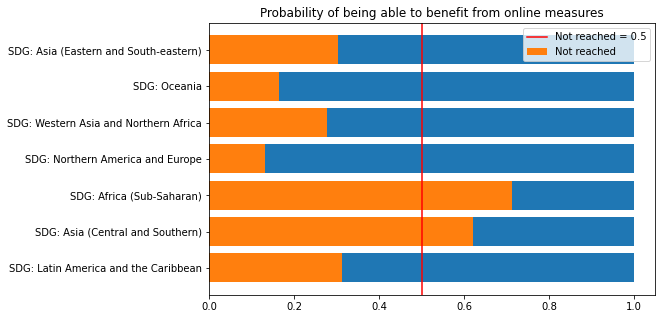

In [67]:
import matplotlib.pyplot as plt

groups = data.sdg_group.unique()
p_benefit_online = dict()

for group in groups:
    if group not in p_benefit_online:
      p_benefit_online[group] = infer.query(["InternetAccess"], evidence={"Group": group, "Online": "yes"}, show_progress=False).values[1]
    else:
      p_benefit_online[group] *= infer.query(["InternetAccess"], evidence={"Group": group, "Online": "yes"}, show_progress=False).values[1]
    
plt.figure(figsize=(8, 5))
plt.barh(list(p_benefit_online.keys()), [1 for _ in p_benefit_online.values()])
plt.barh(list(p_benefit_online.keys()), list(p_benefit_online.values()), label="Not reached")
plt.axvline(x=.5, ymin=0, ymax=1, color="red", label="Not reached = 0.5")
plt.title("Probability of being able to benefit from online measures")
plt.legend()
plt.show()

Indeed from some regions children can't actually benefit from the online learning platforms since they don't have any internet access at all.

  0%|          | 0/4 [00:00<?, ?it/s]

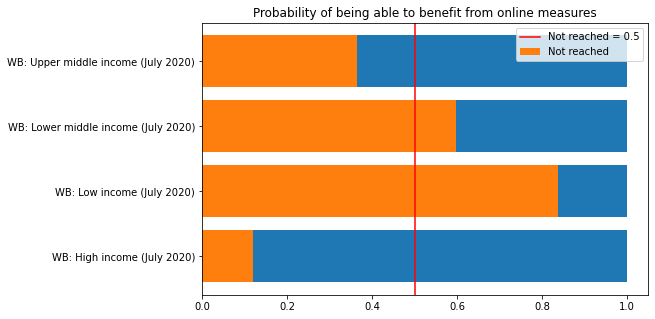

In [68]:
from tqdm.notebook import tqdm

groups = data.wb_group.unique()
p_benefit_online = dict()

for group in tqdm(groups):
  countries_in_group = data[data.wb_group == group].country_id.unique()
  
  for country in countries_in_group:
    p = infer.query(["InternetAccess"], evidence={"Country": country, "Online": "yes"}, show_progress=False).values[1]
    
    if group not in p_benefit_online:
      p_benefit_online[group] = p
    else:
      p_benefit_online[group] += p
  
  p_benefit_online[group] /= len(countries_in_group)
      
plt.figure(figsize=(8, 5))
plt.barh(list(p_benefit_online.keys()), [1 for _ in p_benefit_online.values()])
plt.barh(list(p_benefit_online.keys()), list(p_benefit_online.values()), label="Not reached")
plt.axvline(x=.5, ymin=0, ymax=1, color="red", label="Not reached = 0.5")
plt.title("Probability of being able to benefit from online measures")
plt.legend()
#plt.show()
plt.savefig("online_reach_wb")

In fact the gap is even higher if we compare countries by their economical classification. Students from low income areas have an $\approx 80\%$ probability of being unable to use the online learning platforms provided by the government.

#### School closed

We've seen how, from low income areas, students can't reliably access online lessons.
But how many students are actually learning from home?

Let's first see how likely it is that a child stayed at home because of COVID-19 during the analysed period.

In [69]:
print(infer.query(["AtHome"], show_progress=False))

+-------------+---------------+
| AtHome      |   phi(AtHome) |
+=============+===============+
| AtHome(yes) |        0.5320 |
+-------------+---------------+
| AtHome(no)  |        0.4680 |
+-------------+---------------+


It seems like, for the majority of the analysed period, students where not able to go to school in presence

  0%|          | 0/180 [00:00<?, ?it/s]

<AxesSubplot:>

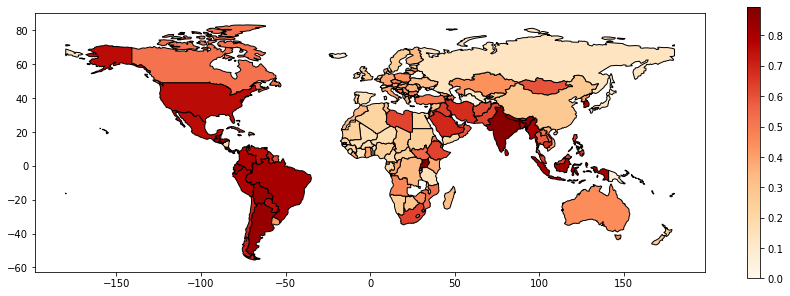

In [70]:
import geopandas
from tqdm.notebook import tqdm

countries_p_athome = list()
for country in tqdm(data.country_id.unique()):
  p = infer.query(["AtHome"], evidence={"Country": country}, show_progress=False)
  countries_p_athome.append(p.values[0])

df = pd.DataFrame(countries_p_athome, index=data.country_id.unique(), columns=["athome"])
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.join(df, on="iso_a3")
world.plot(column="athome", figsize=(15, 5), cmap='OrRd', edgecolor='k', legend=True)

In fact, a lot of countries display a low probability of school's being closed.

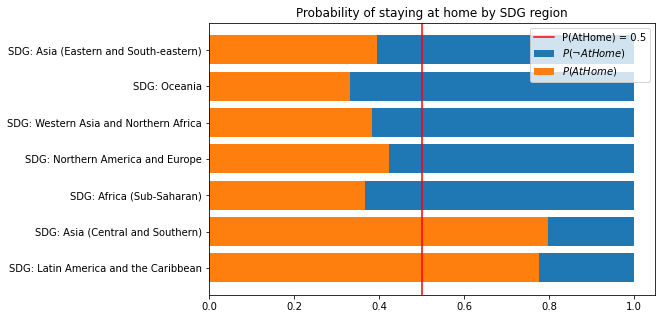

In [71]:
groups = data.sdg_group.unique()
p_group = np.zeros_like(groups)
for idx, group in enumerate(groups):
  p = infer.query(["AtHome"], evidence={"Group": group}, show_progress=False)
  p_group[idx] = p.values[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.barh(groups, np.ones_like(p_group), label="$P(\\neg AtHome)$")
plt.barh(groups, p_group, label="$P(AtHome)$")
plt.axvline(x=.5, ymin=0, ymax=1, color="red", label="P(AtHome) = 0.5")
plt.title("Probability of staying at home by SDG region")
plt.legend()
plt.savefig("athome_sdg_group")
plt.show()

Much like before schools closure are more consistent on asian and Latin America's countries.

  0%|          | 0/4 [00:00<?, ?it/s]

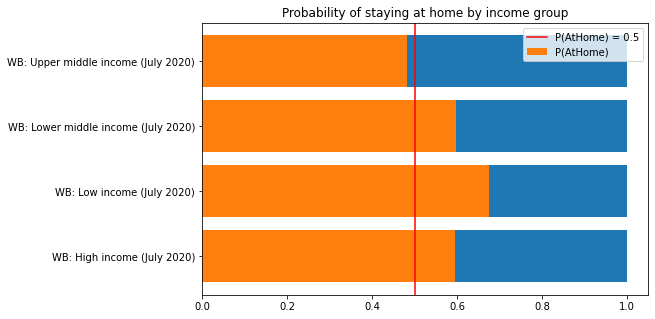

In [72]:
from tqdm.notebook import tqdm

groups = data.wb_group.unique()
p_benefit_online = dict()

for group in tqdm(groups):
  countries_in_group = data[data.wb_group == group].country_id.unique()
  
  for country in countries_in_group:
    p = infer.query(["AtHome"], evidence={"Country": country}, show_progress=False).values[1]
    
    if group not in p_benefit_online:
      p_benefit_online[group] = p
    else:
      p_benefit_online[group] += p
  
  p_benefit_online[group] /= len(countries_in_group)
      
plt.figure(figsize=(8, 5))
plt.barh(list(p_benefit_online.keys()), [1 for _ in p_benefit_online.values()])
plt.barh(list(p_benefit_online.keys()), list(p_benefit_online.values()), label="P(AtHome)")
plt.axvline(x=.5, ymin=0, ymax=1, color="red", label="P(AtHome) = 0.5")
plt.title("Probability of staying at home by income group")
plt.legend()
plt.savefig("athome_wb_group")
plt.show()

Again, low income areas contain those countries whose school closure have been more consistent. This kind of behaviour is however well spread also among other income areas.
We need to take into account, however, that the period of analysis ranges from the initial phase of the pandemic to the end of 2021.
At the beginning of the new school year, around september/october 2020 many country started to allow students back into school without any limitation.

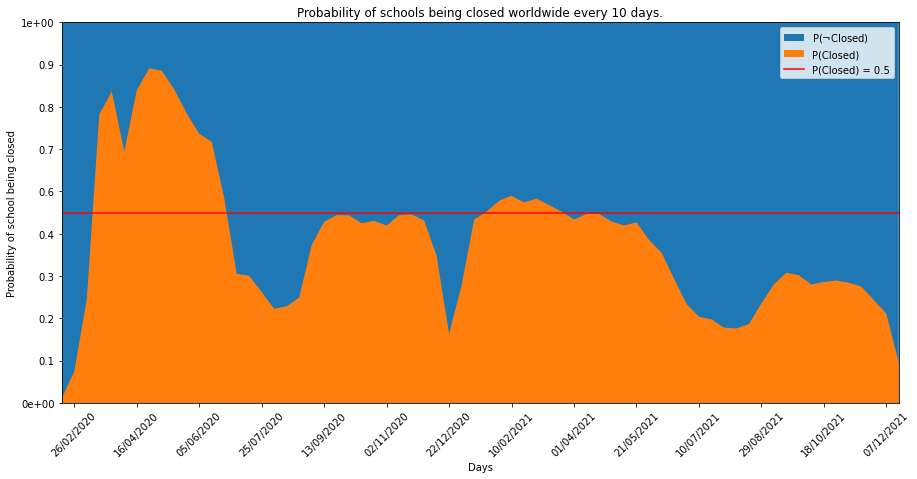

In [73]:
dates = pd.Series(data.date.unique())
dates = zip(dates[0::10], dates[10::10])

athome = dict()

for start, end in dates:
  inrange = data[(data.date >= start) & (data.date < end)]
  tot_days = len(inrange.status)
  at_home = inrange.status.isin(["Closed due to COVID-19", "Partially open"]).sum()
  athome[end] = at_home / tot_days

days = list(athome.keys())
fig = plt.figure(figsize=(15, 7))
plt.fill_between(range(len(days)), days, label="P($\\neg$Closed)")
plt.fill_between(range(len(days)), list(athome.values()), label="P(Closed)")
plt.xticks(range(1, len(days), 5), [d.strftime("%d/%m/%Y") for d in days[::5]], rotation=45)
plt.yticks(np.linspace(0, 1, 10), [f"{x:1.1}" for x in np.linspace(0, 1, 10)])
plt.xlabel("Days")
plt.ylabel("Probability of school being closed")
plt.title("Probability of schools being closed worldwide every 10 days.")
plt.axhline(y=.5, xmin=0, xmax=1, color="red", label="P(Closed) = 0.5")
plt.ylim(0, 1)
plt.xlim(0, len(days) - 1)
plt.legend()
plt.savefig("school_closed_windows")
plt.show()

In fact school closure changes over time: school quickly ramp up to be closed in the middle of the first pandemic round (around mid March 2020) and oscillates between $30\%$ and $50\%$ of likelihood of being closed after June 2020.

In [76]:
print(infer.query(["Education"], evidence={"AtHome": "yes"}, show_progress=False))

+----------------------------+------------------+
| Education                  |   phi(Education) |
+============================+==================+
| Education(primary)         |           0.5264 |
+----------------------------+------------------+
| Education(lower_secondary) |           0.2570 |
+----------------------------+------------------+
| Education(upper_secondary) |           0.2167 |
+----------------------------+------------------+


The probability of staying at home changes between different education degree. That is related to the fact that in many under-developed countries higher education isn't always guaranteed for all the students.

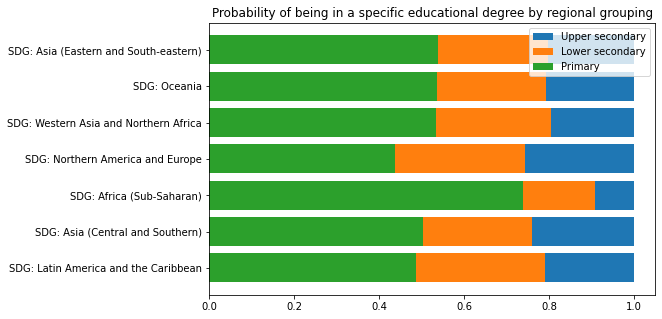

In [77]:
groups = data.sdg_group.unique()
p_primary = np.zeros_like(groups)
p_ls = np.zeros_like(groups)
p_us = np.zeros_like(groups)
for idx, group in enumerate(groups):
  p = infer.query(["Education"], evidence={"Group": group}, show_progress=False)
  p_primary[idx] = p.values[0]
  p_ls[idx] = p.values[1]
  p_us[idx] = p.values[2]

plt.figure(figsize=(8, 5))
plt.barh(range(len(p_primary)), p_primary + p_ls + p_us, label="Upper secondary")
plt.barh(range(len(p_primary)), p_primary + p_ls, label="Lower secondary")
plt.barh(range(len(p_primary)), p_primary, label="Primary")
plt.title("Probability of being in a specific educational degree by regional grouping")
plt.yticks(range(len(groups)), groups)
plt.legend()
plt.savefig("specific_grade_sdg")
plt.show()

Indeed higher educational degrees are only well spread in Northern America, Europe and Asia.

In [40]:
print("Probability of staying at home in SDG: Africa (Sub-Saharan) region:")
print(infer.query(["Education"], evidence={"AtHome": "yes", "Group": "SDG: Africa (Sub-Saharan)"}, show_progress=False))

print("\n\nProbability of staying at home in SDG: Northern America and Europe region:")
print(infer.query(["Education"], evidence={"AtHome": "yes", "Group": "SDG: Northern America and Europe"}, show_progress=False))

Probability of staying at home in SDG: Africa (Sub-Saharan) region:
+----------------------------+------------------+
| Education                  |   phi(Education) |
+============================+==================+
| Education(primary)         |           0.7491 |
+----------------------------+------------------+
| Education(lower_secondary) |           0.1608 |
+----------------------------+------------------+
| Education(upper_secondary) |           0.0901 |
+----------------------------+------------------+


Probability of staying at home in SDG: Northern America and Europe region:
+----------------------------+------------------+
| Education                  |   phi(Education) |
+============================+==================+
| Education(primary)         |           0.4568 |
+----------------------------+------------------+
| Education(lower_secondary) |           0.2837 |
+----------------------------+------------------+
| Education(upper_secondary) |           0.2594 |
+----

If we only take into account Northern America and Europe and compare it to Sub-Saharan Africa the educational gap is even higher.

#### Mental health conditions

As we've already mentioned, distant learning plays an important role on students mental health. Many students repoerted higher level of depression and sleep disorder than they did before the lockdown and the distant learning measures.

In [41]:
x, _ = infer.query(["Anxiety"], evidence={"AtHome": "no"}, show_progress=False).values
print(f"P(Anxiety) = {x} when not in distant learning")
x, _ = infer.query(["Anxiety"], evidence={"AtHome": "yes"}, show_progress=False).values
print(f"P(Anxiety) = {x} when in distant learning")

x, _ = infer.query(["Depression"], evidence={"AtHome": "no"}, show_progress=False).values
print(f"P(Depression) = {x} when not in distant learning")
x, _ = infer.query(["Depression"], evidence={"AtHome": "yes"}, show_progress=False).values
print(f"P(Depression) = {x} when in distant learning")

P(Anxiety) = 0.2403 when not in distant learning
P(Anxiety) = 0.4286 when in distant learning
P(Depression) = 0.297 when not in distant learning
P(Depression) = 0.513 when in distant learning


It's quite clear how the increase in mental health problem due to distant learning is a substiantial problem that needs to be correctly addressed.

  0%|          | 0/68 [00:00<?, ?it/s]

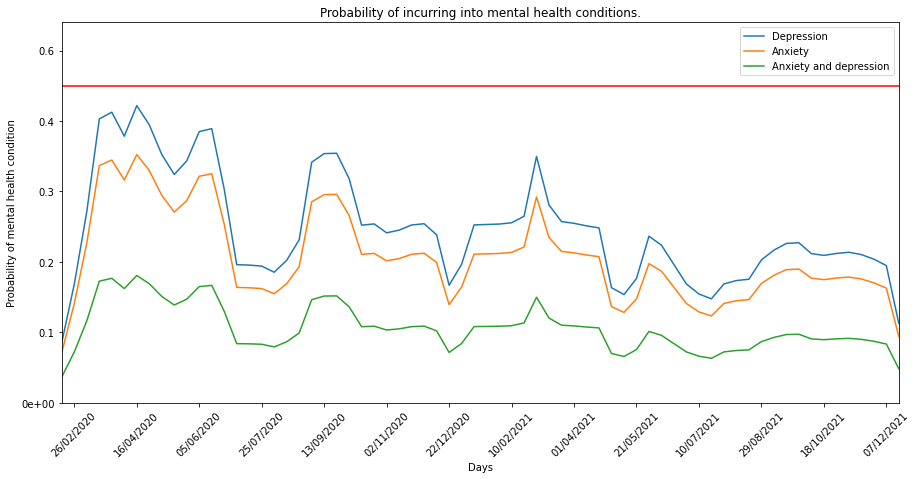

In [78]:
dates = pd.Series(data.date.unique())
dates = list(zip(dates[0::10], dates[10::10]))

depression = list()
anxiety = list()
anxiety_and_depression = list()

for start, end in tqdm(dates):
  inrange = data[(data.date >= start) & (data.date < end)]
  
  p_athome = np.zeros(country_pop.count())
  for idx, (country, df) in enumerate(inrange.groupby("country_id")):
    tot_days = len(df.status)
    at_home = df.status.isin(["Closed due to COVID-19", "Partially open"]).sum()
    p_athome[idx] = at_home / tot_days
  
  cpd_AtHome_tmp = TabularCPD(variable="AtHome", 
                              variable_card=2, 
                              values=np.array([p_athome, 1 - p_athome]),
                              evidence=["Country"],
                              evidence_card=[len(countries)],
                              state_names=state_names)
  model_tmp = model.copy()
  model_tmp.add_cpds(cpd_AtHome_tmp)
  infer_tmp = VariableElimination(model_tmp)
  
  depression.append(infer_tmp.query(["Depression", "AtHome"], show_progress=False).values[0, 0])
  anxiety.append(infer_tmp.query(["Anxiety", "AtHome"], show_progress=False).values[0, 0])
  anxiety_and_depression.append(infer_tmp.query(["Anxiety", "Depression", "AtHome"], show_progress=False).values[0, 0, 0])

fig = plt.figure(figsize=(15, 7))
plt.plot(depression, label="Depression")
plt.plot(anxiety, label="Anxiety")
plt.plot(anxiety_and_depression, label="Anxiety and depression")
plt.xticks(range(1, len(days), 5), [d.strftime("%d/%m/%Y") for d in days[::5]], rotation=45)
plt.yticks(np.linspace(0, 1, 10), [f"{x:1.1}" for x in np.linspace(0, 1, 10)])
plt.xlabel("Days")
plt.ylabel("Probability of mental health condition")
plt.title("Probability of incurring into mental health conditions.")
plt.axhline(y=.5, xmin=0, xmax=1, color="red")
plt.ylim(0, 0.6)
plt.xlim(0, len(days) - 1)
plt.legend()
plt.savefig("meantal_health_window")
plt.show()

Of course the probability of incurring into mental health conditions follows a similar pattern. Depression and anxiety are not indipendent event, they are indeed strictly correlated and one might be the causation of the other. 
However with this kind of analysis it's easy to see how high the values can ramp up. Nearly half of the students, in the middle of the lockdown, are predicted to have suffered some kind of depressive symptom.